In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_context('paper')
sns.set_style({'axes.axisbelow': True, 
               'axes.edgecolor': '.15',
               'axes.facecolor': 'white',
               'axes.grid': True, 
               'axes.labelcolor': '.15', 
               'figure.facecolor': 'white', 
               'grid.color': '.15',
               'grid.linestyle': ':', 
               'grid.alpha': .5, 
               'image.cmap': 'Greys', 
               'legend.frameon': False, 
               'legend.numpoints': 1, 
               'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'butt', 
               'axes.spines.right': False, 
               'axes.spines.top': False,  
               'text.color': '.15',  
               'xtick.top': False, 
               'ytick.right': False, 
               'xtick.color': '.15',
               'xtick.direction': 'out', 
               'ytick.color': '.15', 
               'ytick.direction': 'out', 
              })


import matplotlib

FONT_SIZE_PT = 5
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = FONT_SIZE_PT
matplotlib.rcParams['axes.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['axes.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['figure.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['xtick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['ytick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.fontsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.title_fontsize'] = FONT_SIZE_PT

matplotlib.rcParams['xtick.major.size'] = matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = matplotlib.rcParams['ytick.major.width'] = 0.5


matplotlib.rcParams['xtick.minor.size'] = matplotlib.rcParams['ytick.minor.size'] = 1

matplotlib.rcParams['xtick.minor.width'] = matplotlib.rcParams['ytick.minor.width'] = 0.5

matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['patch.linewidth'] = 0.25
matplotlib.rcParams['lines.markeredgewidth'] = 0.25
matplotlib.rcParams['lines.markersize'] = 2

FIVE_MM_IN_INCH = 0.19685
DPI = 600
matplotlib.rcParams['figure.figsize'] = (10 * FIVE_MM_IN_INCH, 9 * FIVE_MM_IN_INCH)
matplotlib.rcParams['savefig.dpi'] = DPI
matplotlib.rcParams['figure.dpi'] = DPI // 4


#http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)
    
def output_path(basename):
    return os.path.join(OUTPUT_DIRECTORY, basename)

In [3]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import *

In [4]:
from snapanalysis.models.ptm_response.main import FDR_THRESHOLD_RESPONSE, FC_THRESHOLD_RESPONSE
from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER

In [5]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE

limma_results = pd.read_hdf(PTM_RESPONSE_FILE, '/ptm_stats/joint_limma_stats')

long_matrices = {}

for predictor in limma_results.reset_index()['predictor'].unique():
    long_matrices[predictor] = pd.read_hdf(PTM_RESPONSE_FILE, f'/ptm_stats/{predictor}/long_matrix')

In [6]:
from snapanalysis.preprocessing.pulldown_metadata import OUTPUT_FILE as META_FILE
with pd.HDFStore(META_FILE, 'r') as store:
    for key in store.keys():
        print(key)
    pd_predictor_matrix = store['/meta/predictors']
    n_predictors = pd_predictor_matrix.sum(axis=1)
    
    pd_names = store['/meta/names_and_types']

from snapanalysis.models.ptm_response.predictor_graph import EDGE_SEPARATOR, SPECIAL_PULLDOWN
def parse_edge(edge):
    left, __, right = edge.partition(EDGE_SEPARATOR)
    
    
    if right == SPECIAL_PULLDOWN:
        return [left]
    else:
        return [left, right]
    
def edge_sortkey(edge):
    edge = parse_edge(edge)
    return (len(edge), min([n_predictors.loc[x] for x in edge]))

def edge_name(edge):
    edge = parse_edge(edge)
    
    max_pd = max(edge, key=lambda x: n_predictors.loc[x])
    
    return pd_names.loc[max_pd, 'Pull-Down name'].strip()



/meta/color_palette
/meta/coloured_predictors
/meta/coloured_predictors_directionalised
/meta/coloured_predictors_directionalised_with_nulls
/meta/coloured_predictors_with_nulls
/meta/dates
/meta/dna
/meta/names_and_types
/meta/octamers
/meta/octamers_categorical
/meta/predictors
/meta/predictors_categorical
/meta/predictors_categorical_directionalised
/meta/predictors_categorical_directionalised_long
/meta/predictors_web
/meta/predictors_with_redundancy


In [7]:
mean_effect_matrices = {}

for predictor, lm in long_matrices.items():
    lm = lm.reset_index()
    mnrm = lm.query('ptm == True')
    mnrm = mnrm.groupby(['Gene label', 'edge'])['normed_ratio'].mean()
    mnrm = mnrm.unstack('edge')
    
    edge_order = sorted(mnrm.columns, key=edge_sortkey)
    
    mnrm = mnrm.reindex(edge_order, axis=1)
    
    mean_effect_matrices[predictor] = mnrm

In [8]:
PROTEINS = ['CBX8', 'CBX4']
PALETTE = {
    'CBX8': '#9CBBD4',
    'CBX4': '#D7A28F',
}

In [9]:
ORDER = [
    'H2A.Z', 'DNA Methylation', 'H3K4me1', 'H3K4me3', 'H3ac', 'H3K9acK14ac', 'H3K27ac', 'H3K9me2', 'H3K9me3', 'H3K27me2', 'H3K27me3', 'H4ac', 'H4K16ac', 'H4K20me2', 'H4K20me3'
]

-0.225
CBX4 H4K20me3 4
CBX4 H4K20me2 8
CBX4 H4K16ac 8
CBX4 H4ac 5
CBX4 H3K27me3 6
CBX4 H3K27me2 2
CBX4 H3K9me3 4
CBX4 H3K9me2 2
CBX4 H3K27ac 2
CBX4 H3K9acK14ac 8
CBX4 H3ac 6
CBX4 H3K4me3 5
CBX4 H3K4me1 5
CBX4 DNA Methylation 9
CBX4 H2A.Z 3
0.22499999999999995
CBX8 H4K20me3 4
CBX8 H4K20me2 8
CBX8 H4K16ac 8
CBX8 H4ac 5
CBX8 H3K27me3 6
CBX8 H3K27me2 2
CBX8 H3K9me3 4
CBX8 H3K9me2 2
CBX8 H3K27ac 2
CBX8 H3K9acK14ac 8
CBX8 H3ac 6
CBX8 H3K4me3 5
CBX8 H3K4me1 5
CBX8 DNA Methylation 9
CBX8 H2A.Z 3


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


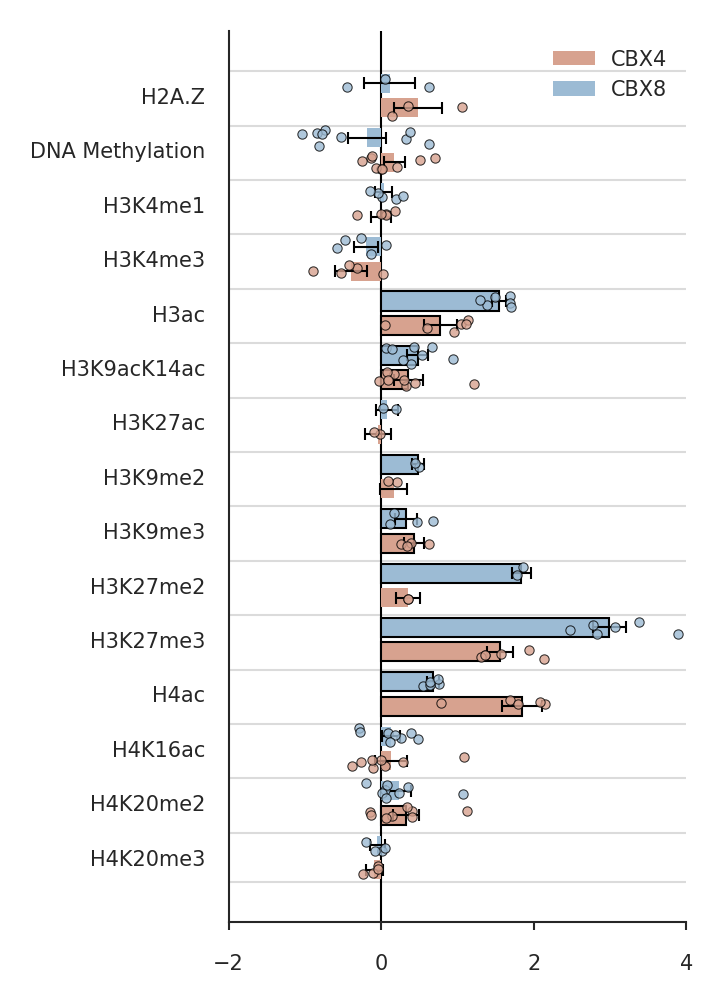

In [10]:
fig = plt.figure(figsize=(FIVE_MM_IN_INCH*10, FIVE_MM_IN_INCH*20))
ax = plt.gca()

total_width = 0.9
bar_width = 0.35
spacing = 0.1
jitter = (bar_width / 2) * 0.9

rs = np.random.RandomState(123)


for i, protein in enumerate(reversed(PROTEINS)):
    
    color = PALETTE[protein]
    
    protein_offset = -total_width / 4 + i * (bar_width + spacing)
    
    print(protein_offset)
    
    first_legend = True
    
    for ycoord, predictor in enumerate(reversed(ORDER)):
        
        mims = mean_effect_matrices[predictor].loc[protein]
        print(protein, predictor, len(mims[~pd.isnull(mims)]))
            
        ycoord_w_offset = ycoord+protein_offset
        
        if i == 0:
            
            ax.axhline(ycoord + total_width/2, color='#DBDBDB', zorder=0)
            
            if ycoord == 0:
                ax.axhline(ycoord - total_width/2, color='#DBDBDB', zorder=0)
        
        ycoord_mims = np.repeat(ycoord_w_offset, len(mims))
        ycoord_mims += rs.uniform(-jitter, +jitter, size=len(mims))
        
        subdata = limma_results.loc(axis=0)[predictor, protein]
        
        center = subdata['logFC']
        error = subdata['CI.R'] - center

        assert np.abs(((center - subdata['CI.L']) - error)) < 0.001
        
        significant = subdata['significant']
        
        bar_kwargs = dict()
        if significant:
            bar_kwargs['edgecolor'] = 'black'
            bar_kwargs['linewidth'] = 0.5
    
        if not significant:
            # Add legend only once, and add non-significant for legend
            if first_legend:
                bar_kwargs = dict(label=protein)
                
            first_legend=False
        
        ax.barh(
            width=center, 
            y=ycoord_w_offset, 
            xerr=error, 
            color=color, 
            height=bar_width,
            capsize=1.5,
            error_kw=dict(elinewidth=0.5, capthick=0.5),
            **bar_kwargs
        )
        
        ax.scatter(
            x=mims.values,
            y=ycoord_mims,
            color=color,
            s=5,
            marker='o',
            edgecolor='black',
            linewidth=0.25,
            zorder=5,
            alpha=.8,
        )
        
ax.axvline(0, color='black', zorder=0)
ax.set_xlim(-2, 4)
ax.set_yticks(range(len(ORDER)))
ax.set_yticklabels(reversed(ORDER))

ax.set_xticks([-2,0, 2,4])
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.tick_params(axis='y', length=0)

# sns.despine(offset=1.0, ax=ax, trim=False)
ax.legend(loc='upper right')

plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'ptm-response-cbx4-cbx8.pdf'), bbox_inches='tight', dpi=600)
